O conjunto de dados diabetes é um conjunto de dados incorporado no scikit-learn.

age: Idade do paciente.
sex: Sexo do paciente (0=feminino, 1=masculino).
bmi: Índice de Massa Corporal (IMC) do paciente.
bp: Pressão sanguínea média do paciente.
s1 a s6: Seis medidas diferentes relacionadas ao soro sanguíneo do paciente. 
target: Uma medida quantitativa de progressão da diabetes um ano após o início do estudo.

In [1]:
from sklearn import datasets
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Aceder aos dados:
diabetes = datasets.load_diabetes()
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)     #variaveis independentes
y = diabetes.target  #variavel dependente


In [3]:
# Adicionar uma coluna de uns para o termo constante
X_1 = sm.add_constant(X)

In [4]:
# Ajustar o modelo de regressão linear múltipla e visualizar os resultados
model = sm.OLS(y, X_1).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Thu, 30 Nov 2023   Prob (F-statistic):           3.83e-62
Time:                        18:51:06   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.576     59.061      0.0

Verificar pressupostos

In [5]:
# Calcular os resíduos
residuals = model.resid

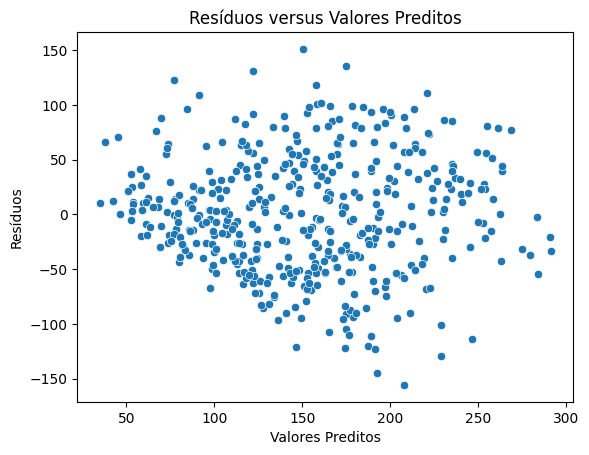

In [6]:
# 1.Linearidade e homocedasticidade (resíduos versus preditos)
sns.scatterplot(x=model.fittedvalues, y=residuals)
plt.title('Resíduos versus Valores Preditos')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.show()

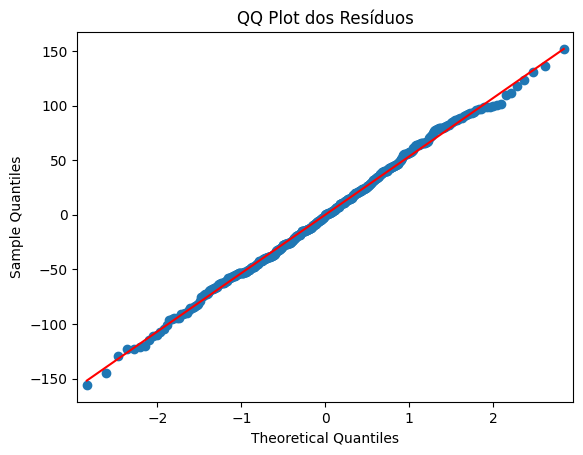

Teste de Shapiro-Wilk - Estatística: 0.9970647692680359, Valor p: 0.6161732077598572


In [7]:
# 2. Normalidade dos resíduos (QQ Plot e Teste de Shapiro-Wilk)
sm.qqplot(residuals, line='s')
plt.title('QQ Plot dos Resíduos')
plt.show()
# Teste de Shapiro-Wilk
stat, p_value = shapiro(residuals)
print(f'Teste de Shapiro-Wilk - Estatística: {stat}, Valor p: {p_value}')

In [8]:
# 3. Independência dos resíduos (Teste de Durbin-Watson)
durbin_watson_stat = durbin_watson(residuals)
print(f'Teste de Durbin-Watson: {durbin_watson_stat}')

#Se o valor de DW estiver próximo a 2, sugere que não há autocorrelação significativa nos resíduos.
#Se o valor de DW for significativamente menor que 2, sugere autocorrelação positiva.
#Se o valor de DW for significativamente maior que 2, sugere autocorrelação negativa.

Teste de Durbin-Watson: 2.028543219254427


In [9]:
# 4. Identificar outliers (resíduos padronizados > 2)
std_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
outliers_indices = np.where(np.abs(std_residuals) > 2)[0]
print("Índices dos outliers:", outliers_indices)

Índices dos outliers: [ 37  56  77  92 102 156 205 236 274 289 290 304 328 359 363 380 382 387]


In [10]:
# Obter a distância de Cook para cada observação
influence = model.get_influence() #medidas de influência
(cook, p) = influence.cooks_distance

# Mostrar a distância de Cook (>1 indica ser influente) e os valores de p (H0:dCook=0)
for i in outliers_indices:
    print(f'Observação {i}: Distância de Cook = {cook[i]}, p-value = {p[i]}')

Observação 37: Distância de Cook = 0.006658584127323117, p-value = 0.9999999999550915
Observação 56: Distância de Cook = 0.011802652467805388, p-value = 0.9999999989791356
Observação 77: Distância de Cook = 0.011539290937874154, p-value = 0.999999999097161
Observação 92: Distância de Cook = 0.01813289473039356, p-value = 0.9999999894911359
Observação 102: Distância de Cook = 0.017451107100151464, p-value = 0.9999999914606937
Observação 156: Distância de Cook = 0.003327211233421032, p-value = 0.9999999999989952
Observação 205: Distância de Cook = 0.010524414218609682, p-value = 0.9999999994532182
Observação 236: Distância de Cook = 0.006199717797860223, p-value = 0.9999999999696104
Observação 274: Distância de Cook = 0.005089915323823118, p-value = 0.9999999999896751
Observação 289: Distância de Cook = 0.015459209432126123, p-value = 0.9999999955736529
Observação 290: Distância de Cook = 0.005662441903540266, p-value = 0.999999999981494
Observação 304: Distância de Cook = 0.018943752669

In [11]:
# 5. Multicolinearidade (Fator de Inflação de Variância - VIF)
vif = pd.DataFrame()  #cria um dataframe vazio para armazenar as informações do VIF
vif["Variável"] = X.columns #adiciona uma coluna "Variável" com os nomes das variáveis
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
## Adiciona a coluna "VIF" e calcula o VIF para cada variável de X
print("\nFator de Inflação de Variância (VIF):\n")
print(vif)


Fator de Inflação de Variância (VIF):

  Variável        VIF
0      age   1.217307
1      sex   1.278071
2      bmi   1.509437
3       bp   1.459428
4       s1  59.202510
5       s2  39.193370
6       s3  15.402156
7       s4   8.890986
8       s5  10.075967
9       s6   1.484623


In [12]:
#retirar a variável 's1'
X = data.drop('s1', axis=1)
vif = pd.DataFrame()  
vif["Variável"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nFator de Inflação de Variância (VIF):\n")
print(vif)

NameError: name 'data' is not defined

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.271e+31
Date:                Thu, 30 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:07:53   Log-Likelihood:                 12863.
No. Observations:                 442   AIC:                        -2.570e+04
Df Residuals:                     431   BIC:                        -2.566e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.807e-14   8.04e-15      5.976      0.0

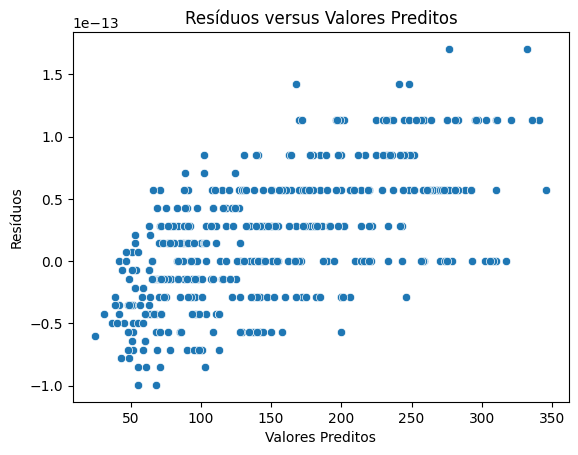

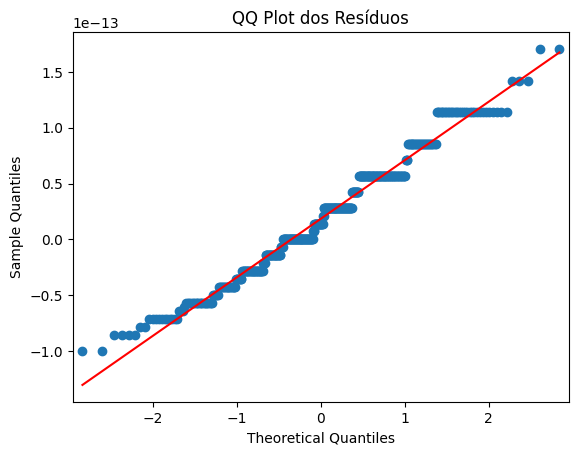

Teste de Shapiro-Wilk - Estatística: 0.9779614210128784, Valor p: 3.0386763683054596e-06
Teste de Durbin-Watson: 1.8042009740049716
Índices dos outliers: [ 22 204 273 290 323 402 417]
Observação 22: Distância de Cook = 0.00579113385632384, p-value = 0.9999999999790722
Observação 204: Distância de Cook = 0.029649005541334393, p-value = 0.999999851320274
Observação 273: Distância de Cook = 0.015106929370842901, p-value = 0.9999999960941718
Observação 290: Distância de Cook = 0.021088309194841993, p-value = 0.9999999762257351
Observação 323: Distância de Cook = 0.02937843342741508, p-value = 0.9999998584492962
Observação 402: Distância de Cook = 0.019500763333381323, p-value = 0.99999998442448
Observação 417: Distância de Cook = 0.01021924145964558, p-value = 0.9999999995342426


In [ ]:
# Refazer o modelo de regressão linear sem s1

X_1 = sm.add_constant(X)
model = sm.OLS(y, X_1).fit()
print(model.summary())
residuals = model.resid
# Gráfico dos resíduos versus preditos
sns.scatterplot(x=model.fittedvalues, y=residuals)
plt.title('Resíduos versus Valores Preditos')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.show()
# QQ Plot
sm.qqplot(residuals, line='s')
plt.title('QQ Plot dos Resíduos')
plt.show()
# Teste de Shapiro-Wilk
stat, p_value = shapiro(residuals)
print(f'Teste de Shapiro-Wilk - Estatística: {stat}, Valor p: {p_value}')
# Durbin-Watson
durbin_watson_stat = durbin_watson(residuals)
print(f'Teste de Durbin-Watson: {durbin_watson_stat}')
# Outliers
std_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
outliers_indices = np.where(np.abs(std_residuals) > 2)[0]
print("Índices dos outliers:", outliers_indices)
# Influência dos outliers
influence = model.get_influence() #medidas de influência
(cook, p) = influence.cooks_distance
for i in outliers_indices:
    print(f'Observação {i}: Distância de Cook = {cook[i]}, p-value = {p[i]}')

Regressão linear múltipla utilizando o sklearn

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Dividir os dados em amostras de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar um objeto de regressão linear
regr = LinearRegression()

# Treinar o modelo usando a amostra de treino
regr.fit(X_train, y_train)

# Fazer previsões usando a amostra de teste
y_pred = regr.predict(X_test)

# O erro quadrático médio (MSE=Mean Squared Error)
print('MSE: %.2f' % mean_squared_error(y_test, y_pred))
# Raiz do erro quadrático médio (RMSE=Root Mean Squared Error) 
print('RMSE: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))

# O coeficiente de determinação: 
print('Coeficiente de determinação:', r2_score(y_test, y_pred))

MSE: 0.00
RMSE: 0.00
Coeficiente de determinação: 1.0


Fazer Validação Cruzada

In [ ]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Criar um objeto de regressão linear
regr = LinearRegression()

# Realizar a validação cruzada
R2 = cross_val_score(regr, X, y, cv=5)

print('Scores de validação cruzada: ', R2)
print('Média dos scores de validação cruzada: ', R2.mean())


Scores de validação cruzada:  [1. 1. 1. 1. 1.]
Média dos scores de validação cruzada:  1.0
